
# Setup


## Imports


In [1]:
import functools
import pathlib
from pprint import pprint
import sys
import yaml
from yaml import YAMLObject
from typing import *

import attr
import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils

import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses

tensorflow version: 2.2.0


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from tomo2seg import modular_unet
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import VolumePaths, ModelPaths
from tomo2seg.metadata import Metadata

from cnn_segm.tools.cnn_callbacks import ReduceLROnPlateauBacktrack

## GPUs


In [4]:
# (on R790-TOMO) 2
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
# (on R790-TOMO) CPU:0, XLA_CPU:0, GPU:0, GPU:1, XLA_GPU:0, XLA_GPU:1
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [6]:
# (on R790-TOMO) CPU:0, XLA_CPU:0, GPU:0, GPU:1, XLA_GPU:0, XLA_GPU:1
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:XLA_GPU:1', device_type='XLA_GPU')]

In [7]:
# set xla auto-clustering optimization
# see: https://www.tensorflow.org/xla#auto-clustering
tf.config.optimizer.set_jit(False)
# adendum: this seems to actually break the training

In [8]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy()  # todo add strategy to metadata

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

## File paths


In [9]:
volume_name = data.VOLUME_PRECIPITATES_DRYRUN
volume_paths = data.volume_precipitates_dryrun

logger.info("Working with volume `%s`: %s", volume_name, volume_paths)

[2020-10-15::16:59:48.278] tomo2seg :: INFO :: {<ipython-input-9-1b32abc8a087>:<module>:004}
Working with volume `PA66GF30_trans3_x__0_pag`: VolumePaths(volume_name='PA66GF30_trans3_x__0_pag')


In [10]:
class labels:
  matrix = 0
  fiber = 1
  hole = 2

labels_list = [0, 1, 2]

dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

## Load volumes


In [11]:
train_volume = hst_read(str(volume_paths.train_data_path))
train_labels = hst_read(str(volume_paths.train_labels_path))

val_volume = hst_read(str(volume_paths.val_data_path))
val_labels = hst_read(str(volume_paths.val_labels_path))

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


## Data Sequences

In [12]:
batch_size_per_replica = 16  # todo batch per replica to metadata
batch_size = batch_size_per_replica * mirrored_strategy.num_replicas_in_sync
crop_size = 224  # multiple of 16 (requirement of a 4-level u-net)
n_geometric_augmentations = 3
slice_axes = (0, 1, 2,)

train_generator = VolumeImgSegmSequence(
    source_volume=train_volume, 
    label_volume=train_labels,
    labels=labels_list, 
    axes=slice_axes, 
    batch_size=batch_size,
    shuffle=True,
    normalization_const=255,
    n_geometric_augmentations=n_geometric_augmentations,
    random_state=42,
    crop_size=crop_size,
)

val_generator = VolumeImgSegmSequence(
    source_volume=val_volume, 
    label_volume=val_labels,
    labels=labels_list, 
    axes=(2,), 
    batch_size=10,
    shuffle=False,
    normalization_const=255,
    n_geometric_augmentations=0,
    crop_size=crop_size,
)

# Model

In [13]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)
logger.info("Model paths object: %s", model_paths)

input_shape = (crop_size, crop_size, 1)
nb_filters_0 = 12
model_generator_function = modular_unet.u_net

lr = 4e-3
n_epochs = 30


[2020-10-15::16:59:49.448] tomo2seg :: INFO :: {<ipython-input-13-f6e282210101>:<module>:003}
Model paths object: ModelPaths(model_name='dryrun-03')


In [14]:
with mirrored_strategy.scope():
    if not model_paths.autosaved_model_path.exists():
        assert not model_paths.model_path.exists(), f"Please delete '{model_paths.model_path}' to redefine it."

        model = model_generator_function(input_shape, nb_filters_0=nb_filters_0, output_channels=3, name=model_name)
        model.save(filepath=model_paths.model_path, overwrite=False)

    else:
        logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
        model = keras.models.load_model(model_paths.autosaved_model_path)
        # todo find the epoch that the training stopped at

    optimizer = optimizers.Adam(lr=lr)
    loss_func = losses.categorical_crossentropy    
    
    model.compile(loss=loss_func, optimizer=optimizer)
    model.save(model_paths.model_path)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [15]:
# write the model summary in a file
with model_paths.summary_path.open("w") as f:
    def print_to_txt(line):
        f.writelines([line + "\n"])
    model.summary(print_fn=print_to_txt, line_length=140)

# same for the architecture
utils.plot_model(model, show_shapes=True, to_file=model_paths.architecture_plot_path);

# todo add links to the files here

# Callbacks

In [16]:

# todo add this to summmary?
autosave_cb = callbacks.ModelCheckpoint(
    str(model_paths.autosaved_model_path), 
    monitor="val_loss", 
    verbose=0, 
    save_best_only=True, 
    mode="auto",
)

# todo add this to summary
reduce_lr_cb = ReduceLROnPlateauBacktrack(
    model,
    str(model_paths.autosaved_model_path / "variables"),  # todo move this to inside ModelPaths 
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0,
    min_lr=1e-5,
),

# todo add this to summmary?
logger_cb = callbacks.CSVLogger(
    str(model_paths.logger_path), separator=",", append=False
)

cb = [
    autosave_cb,
    logger_cb,
    callbacks.TerminateOnNaN(),
    reduce_lr_cb,
]

# todo add to summary
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)

In [17]:
# unique, counts = np.unique(train_labels, return_counts=True)
# class_freqs = dict(zip(unique, counts))
# total = sum(class_freqs.values())
# class_freqs = {k: v / total for k, v in class_freqs.items()}
# class_freqs
# class_freqs_inv = {k: 1. / v for k, v in class_freqs.items()}
# class_freqs_inv
# import tensorflow as tf
# from tensorflow.python.keras import backend as K
# weights = [class_freqs_inv[i] for i in range(len(class_freqs_inv))]

# def weighted_cross_entropy(y_true, y_pred):
#   Kweights = K.constant(weights)
#   if not K.is_keras_tensor(y_pred):
#     y_pred = K.constant(y_pred)
#   y_true = K.cast(y_true, y_pred.dtype)
#   return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * y_pred, axis=-1)

# Summary before training

In [18]:
# stuff that i use after the training but i want it to appear in the 
# pre-training summary

## Metadata

In [19]:
# todo also print to a file
# todo plot image samples here
metadata = Metadata.build(
    model, model_paths, 
    volume_paths, train_generator, val_generator,
    model_generator_function, nb_filters_0, input_shape,
    n_epochs
)

print(metadata.yaml_str)
metadata.save_yaml_file(model_paths.metadata_yml_path)

!Metadata
architecture: !Architecture
    input_shape: (224, 224, 1)
    model_generator_function: tomo2seg.modular_unet.u_net
    n_params_nontrainable: 3672
    n_params_nontrainable_human: '3672'
    n_params_total: 2835009
    n_params_total_human: 2.8 million
    n_params_trainable: 2831337
    n_params_trainable_human: 2.8 million
    u_net__n_filters_0: 12
batch_size: 32
learning_rate: '4.00e-03'
loss_func: tensorflow.python.keras.losses.categorical_crossentropy
model_name: dryrun-03
n_batches_per_epoch: 562
n_epochs: 30
n_examples_per_epoch: 17984
n_examples_per_epoch_human: 17,984
optimizer: tensorflow.python.keras.optimizer_v2.adam.Adam
paths: !Paths
    architecture_fig: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-03/summary.txt
    autosave: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-03-autosaved
    history_csv: null
    logger: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-03/logger.csv
    metadata_yml: /home/users/jcasagrande/projects/

## Volume slices

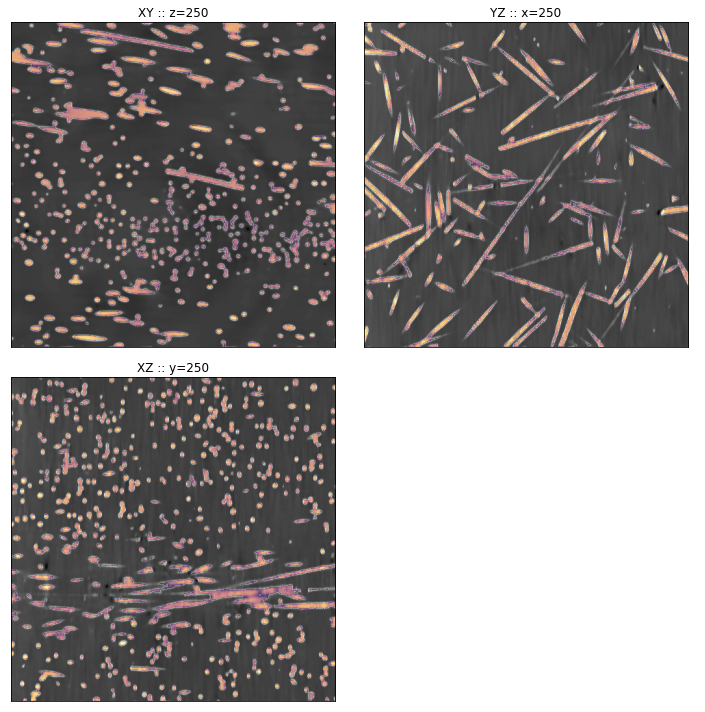

In [20]:
fig, axs = viz.tight_subplots(2, 2, 10, 10)
mask = (~(train_generator.label_volume == labels.fiber)).astype(int)
viz.plot_orthogonal_slices(axs, train_generator.source_volume, mask)

## Generator samples

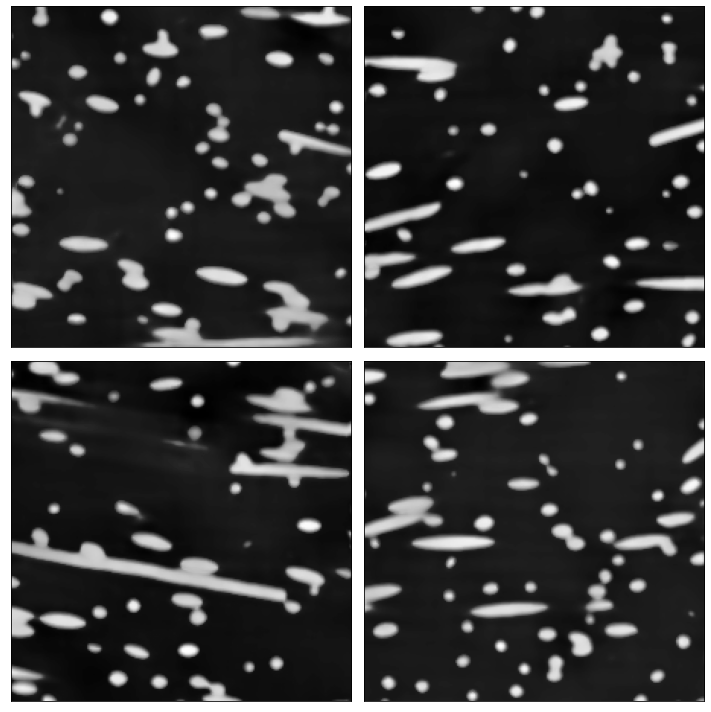

In [21]:
fig, axs = viz.tight_subplots(2, 2, 10, 10)

for ax in axs.ravel():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
random_batches = np.random.RandomState(10).choice(
    list(range(len(train_generator))), 4, replace=False
)
for batch_index, ax in zip(random_batches, axs.ravel()):
    ax.imshow(train_generator[batch_index][0][0, :, :, 0], cmap=cm.gray)

# Training


In [22]:
raise Exception('stop')  # avoid launching the train before taking a look above

Exception: stop

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=20,  # todo put in summary
    epochs=n_epochs,
    callbacks=cb,  # todo mention in summary...
    verbose=1,
    use_multiprocessing=False,   # todo add to summary
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1


# Analyze training


In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

In [ ]:
history_df = pd.DataFrame({**history.history, **{"epochs": history.epoch}})
history_df.to_csv(history_csv_path, index=False)

In [ ]:
model.save(model_paths.model_path)

In [ ]:
# todo add metrics 
# todo add wandb?
# todo add analysis in the end, see examples of classif
# todo add callbacks that generate classif examples
# todo print line that I can cccv on the experiments spreadsheet
# todo save the yaml file
# todo (later): separate the analysis part in a separate script so it 
#  can be called at any time with another model
# todo experiment with CentralStorageStrategy?